In [1]:
from mantis_shrimp.utils import get_photopath, my_transform #, central_crop
from mantis_shrimp.augmentation import augment_fn, augment_fn_latefusion
from mantis_shrimp import models
from mantis_shrimp import datasets
from mantis_shrimp import utils


import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import rotate

from einops import rearrange
from astropy.visualization import make_lupton_rgb

from astropy.visualization import PercentileInterval, AsinhStretch
from scipy.ndimage import zoom

from mantis_shrimp.training import train_epoch, val_epoch
from tqdm import tqdm
import pickle
import random
import argparse
import torchvision


import torch.distributed as dist
from torch.utils.data import DataLoader
from collections import deque

In [2]:
class FakeArgParse():
    def __init__(self):
        self.backend = 'nccl'
        self.fusion_type = 'late'
        self.n_classes = 400
        self.z_max = 1.6
        self.n_epochs = 100
        self.use_amp = 'False'
        self.batchsize = 16 #whatever we set here is actually going to be effectively multipled by n_gpus.
        self.galex = True
        self.unwise = True
args = FakeArgParse()

In [3]:
# lets do these next few by incorporating calPIT
new_cde = np.load('../data/completed_analysis/new_cde.npy',)

In [4]:
N_CLASSES=400
Z_MAX=1.6
device='cpu'

In [5]:
BINS = np.linspace(0,Z_MAX,N_CLASSES+1) #must be the same as CLASS_BINS below
CLASS_BINS_npy = BINS#alias
BINS = BINS.astype(np.float32)[0:-1]
CLASS_BINS = torch.from_numpy(BINS).to(device)

In [6]:
BASEDIR = './../data/completed_analysis/'
os.listdir(BASEDIR)

['data_dict.npy',
 'data_dict_large.npy',
 'new_cde.npy',
 'data_dict_early_ablate_all.npy',
 'data_dict_early_ablate_galex.npy',
 'data_dict_early_ablate_wise.npy',
 'data_dict_late.npy',
 'data_dict_late_ablate_galex.npy',
 'data_dict_late_ablate_wise.npy',
 'data_dict_LS10_test0.npy']

In [7]:
Dictionary_results = np.load(os.path.join(BASEDIR,'data_dict_large.npy'),allow_pickle=True).item()

In [8]:
Dictionary_results_LS10 = np.load(os.path.join(BASEDIR,'data_dict_LS10_test0.npy'),allow_pickle=True).item()

In [9]:
matched_app_dict = np.load('./../data/LS10_photometry/matched_aperature_fluxdict.npy',allow_pickle=True).item()

In [10]:
KIND = 'test'

assert KIND=='test' or KIND=='val'

In [11]:
all_y_hat = Dictionary_results[f'all_y_hat_{KIND}'] 
all_cde_hat = Dictionary_results[f'all_cde_hat_{KIND}'] 
data_y_eval = Dictionary_results[f'data_y_eval_{KIND}']
photoz_MGS = Dictionary_results[f'photoz_MGS_{KIND}']
photoz_WPS = Dictionary_results[f'photoz_WPS_{KIND}']

all_z = data_y_eval #alias

In [12]:
all_y_hat_mode = CLASS_BINS_npy[np.argmax(all_cde_hat,1)]

In [13]:
from mantis_shrimp.utils import cde_loss
from calpit.utils import normalize

In [14]:
y_hat_LS10 = Dictionary_results_LS10['all_y_hat_test']
cde_hat_LS10 = Dictionary_results_LS10['all_cde_hat_test']
y_eval_LS10 = Dictionary_results_LS10['data_y_eval_test']

LS10_mask = Dictionary_results_LS10['LS10_mask']

In [15]:
include_all_bands_mask = np.all(LS10_mask,1)

## My Test

In [16]:
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My Performance on the Entire Dataset: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
CDELOSS, CDELOSS_se = cde_loss(normalize(all_cde_hat,np.linspace(0.0,1.6,N_CLASSES)), CLASS_BINS_npy[0:N_CLASSES], data_y_eval)
print('cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))
#print('CRPS: ',np.round(100*CRPS_,6))
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')

My Performance on the Entire Dataset: 
MAD:  0.024383
BIAS:  0.011515
ETA:  17.597345 % >0.05
cde_loss:  -7.460062  +/-  0.034963


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


In [17]:
residuals_scaled = (all_y_hat_mode - all_z.squeeze())/(1+all_z.squeeze())
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My Performance on the Entire Dataset (Mode): ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
#print('CRPS: ',np.round(100*CRPS_,6))
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')

My Performance on the Entire Dataset (Mode): 
MAD:  0.02452
BIAS:  0.01533
ETA:  17.930957 % >0.05


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


# simply replace with LS10

In [23]:
residuals_scaled = (y_hat_LS10 - y_eval_LS10.squeeze())/(1+y_eval_LS10.squeeze())
residuals_scaled = residuals_scaled[~include_all_bands_mask]
#somehow, when I 

#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My Performance on the Entire Dataset: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
CDELOSS, CDELOSS_se = cde_loss(normalize(all_cde_hat,np.linspace(0.0,1.6,N_CLASSES)), CLASS_BINS_npy[0:N_CLASSES], data_y_eval)
print('cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))
#print('CRPS: ',np.round(100*CRPS_,6))
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')

My Performance on the Entire Dataset: 
MAD:  0.023326
BIAS:  0.01351
ETA:  16.428331 % >0.05


KeyboardInterrupt: 

## My MGS

how many in MGS mask:  102850
My Performance on MGS: 
MAD:  0.009951
BIAS:  -0.00019
ETA:  0.533787 % >0.05
cde_loss:  -26.19033  +/-  0.091792


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


decimal percentage of test dataset in MGS:  0.1195955264179948


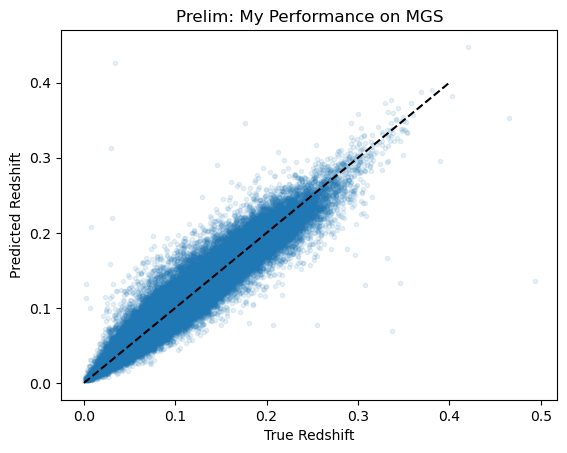

In [14]:
#FIRST get our results using only MGS
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())

MGS_mask = ~np.isnan(photoz_MGS)

print('how many in MGS mask: ',np.sum(MGS_mask))
residuals_scaled = residuals_scaled[MGS_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('My Performance on MGS: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
CDELOSS, CDELOSS_se = cde_loss(normalize(all_cde_hat[MGS_mask],np.linspace(0.0,1.6,N_CLASSES)), CLASS_BINS_npy[0:N_CLASSES], data_y_eval[MGS_mask])
print('cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')
print('\n')
print('decimal percentage of test dataset in MGS: ',np.sum(MGS_mask)/len(MGS_mask))

plt.plot(all_z.squeeze()[MGS_mask],all_y_hat[MGS_mask],'.',alpha=0.1)
plt.title('Prelim: My Performance on MGS')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,0.4],[0,0.4],'k--')
plt.show()

## My PS1 x WISE

how many in WISE-PS1-STRM mask:  596443
My Performance on WISE-PS1-STRM: 
MAD:  0.018618
BIAS:  0.002877
ETA:  6.594595 % >0.05
cde_loss:  -13.040499  +/-  0.0285


decimal percentage of test dataset in WPS:  0.693552888316267


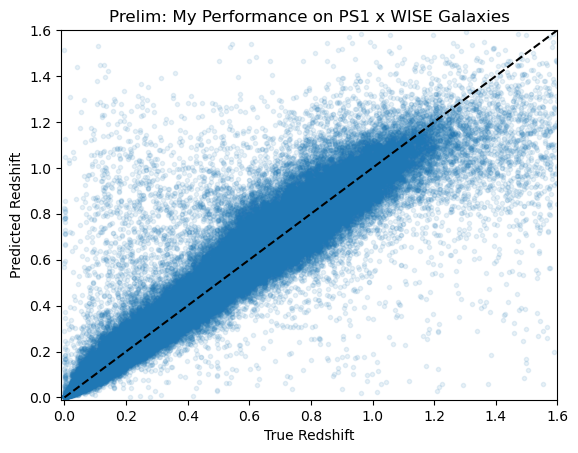

In [15]:
#Next compare to all the available matches in WISE-PS1-STRM
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())

wps_mask = ~np.isnan(photoz_WPS)

print('how many in WISE-PS1-STRM mask: ',np.sum(wps_mask))
residuals_scaled = residuals_scaled[wps_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('My Performance on WISE-PS1-STRM: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
CDELOSS, CDELOSS_se = cde_loss(normalize(all_cde_hat[wps_mask],np.linspace(0.0,1.6,N_CLASSES)), CLASS_BINS_npy[0:N_CLASSES], data_y_eval[wps_mask])
print('cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))
print('\n')
print('decimal percentage of test dataset in WPS: ',np.sum(wps_mask)/len(wps_mask))

plt.plot(all_z.squeeze()[wps_mask],all_y_hat[wps_mask],'.',alpha=0.1)
plt.title('Prelim: My Performance on PS1 x WISE Galaxies')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,args.z_max],[0,args.z_max],'k--')
plt.xlim(-0.01,args.z_max)
plt.ylim(-0.01,args.z_max)
plt.show()

# Histogram of the Residuals

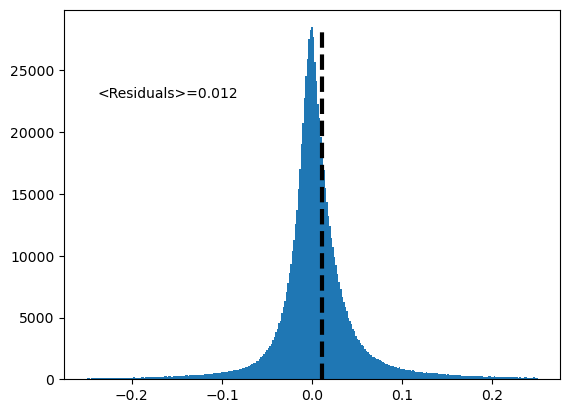

In [16]:
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())

N, bins, __ = plt.hist(residuals_scaled,bins=np.linspace(-0.25,0.25,300),)
plt.vlines(np.mean(residuals_scaled),0,np.max(N),linestyle='dashed',color='k',linewidth=3)
plt.text(0.95*np.min(bins),0.8*np.max(N),'<Residuals>={:.3f}'.format(np.mean(residuals_scaled)))
plt.show()

# Point Metrics in Redshift

In [17]:
new_cde[np.all(new_cde==0,1)] = 1
new_pmf = new_cde/new_cde.sum(1)[:,None] 

In [18]:
cal_y_hat = np.sum(CLASS_BINS_npy[0:-1][None,:]*new_pmf,1)

In [19]:
bins = np.linspace(0,1.6,20)

def get_metrics(residuals_scaled,all_z=all_z):

    MADs = []
    BIASs = []
    ETAs = []
    
    for i in range(len(bins[0:-1])):
        mask =  np.logical_and(bins[i]<all_z,all_z<bins[i+1])

        inner_MAD = []
        inner_BIAS = []
        inner_ETA = []

        for j in range(1000): #bootstrap
            residual_scaled_sample = np.random.choice(residuals_scaled[mask],len(residuals_scaled[mask]),replace=True)
            
            MAD = 1.4826*np.median(abs(residual_scaled_sample - np.median(residual_scaled_sample)))
            BIAS = np.mean(residual_scaled_sample)
            ETA = np.sum(abs(residual_scaled_sample)>=0.05)/len(residual_scaled_sample)
            
            inner_MAD.append(MAD)
            inner_BIAS.append(BIAS)
            inner_ETA.append(ETA)
    
        MADs.append(np.array(inner_MAD))
        BIASs.append(np.array(inner_BIAS))
        ETAs.append(np.array(inner_ETA))

    return np.array(MADs), np.array(BIASs), np.array(ETAs)

In [20]:
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())
residuals_scaled_cal = (cal_y_hat - all_z.squeeze())/(1+all_z.squeeze())

MADs, BIASs, ETAs = get_metrics(residuals_scaled)
MADcal, BIAScal, ETAcal = get_metrics(residuals_scaled_cal)

#compute IQR interval
MADs_qs = np.quantile(MADs,q=[0.158,0.5,0.841],axis=1)
BIASs_qs = np.quantile(BIASs,q=[0.158,0.5,0.841],axis=1)
ETAs_qs = np.quantile(ETAs,q=[0.158,0.5,0.841],axis=1)

MADcal_qs = np.quantile(MADcal,q=[0.158,0.5,0.841],axis=1)
BIAScal_qs = np.quantile(BIAScal,q=[0.158,0.5,0.841],axis=1)
ETAcal_qs = np.quantile(ETAcal,q=[0.158,0.5,0.841],axis=1)

In [32]:
def reformat_error(qs):
    A = np.zeros((2,qs.shape[1]),dtype=qs.dtype)
    below = qs[1] - qs[0]
    A[0,:] = below
    above = qs[2] - qs[1]
    A[1,:] = above
    return A

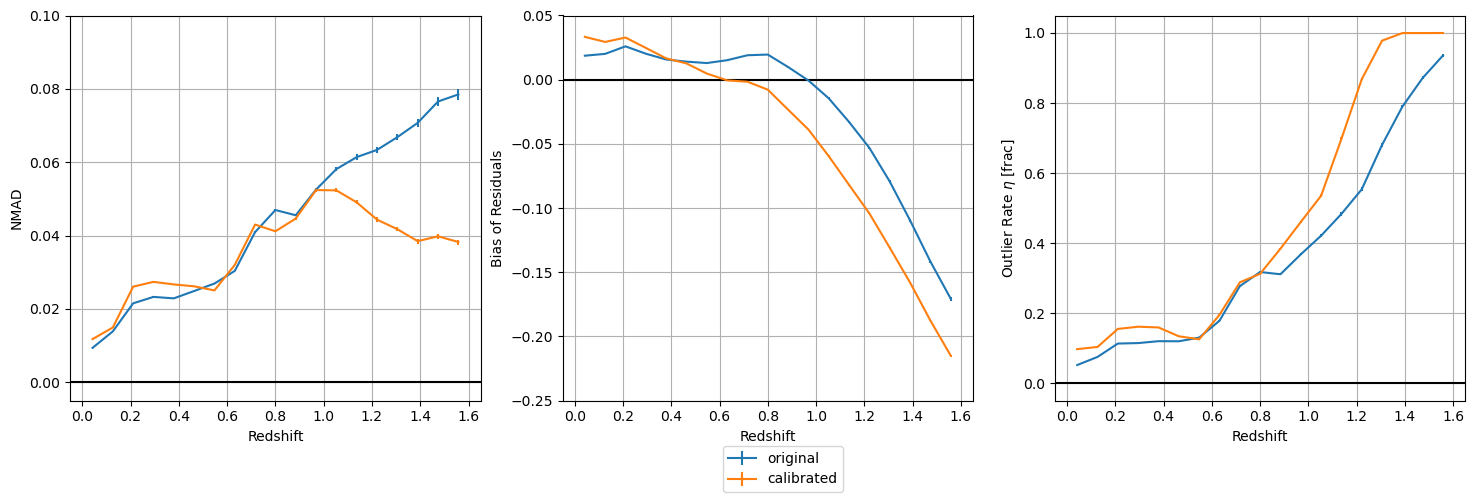

In [22]:
binstep = (bins[1] - bins[0])/2
#plot the result
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.ylabel('NMAD')
plt.hlines(0,-0.05,1.65,color='k')
plt.errorbar(bins[0:-1]+binstep,MADs_qs[1,:],yerr=reformat_error(MADs_qs))
plt.errorbar(bins[0:-1]+binstep,MADcal_qs[1,:],yerr=reformat_error(MADcal_qs))
plt.ylim(-0.005,0.1)
plt.xlim(-0.05,1.65)
plt.xlabel('Redshift')
plt.grid()

plt.subplot(1,3,2)
plt.hlines(0,-0.05,1.65,color='k')
plt.ylabel('Bias of Residuals')
plt.errorbar(bins[0:-1]+binstep,BIASs_qs[1,:],yerr=reformat_error(BIASs_qs))
plt.errorbar(bins[0:-1]+binstep,BIAScal_qs[1,:],yerr=reformat_error(BIAScal_qs))
plt.ylim(-0.25,0.05)
plt.xlim(-0.05,1.65)
plt.xlabel('Redshift')
plt.grid()

plt.subplot(1,3,3)
plt.ylabel(r'Outlier Rate $\eta$ [frac]')
plt.hlines(0,-0.05,1.65,color='k')
plt.errorbar(bins[0:-1]+binstep,ETAs_qs[1,:],yerr=reformat_error(ETAs_qs),label='original')
plt.errorbar(bins[0:-1]+binstep,ETAcal_qs[1,:],yerr=reformat_error(ETAcal_qs),label='calibrated')
plt.ylim(-0.05,1.05)
plt.xlim(-0.05,1.65)
plt.xlabel('Redshift')
plt.grid()

plt.legend(bbox_to_anchor=(-0.5,-0.1))
plt.show()

# Now plot these metrics against SNR

In [16]:
matched_result = matched_app_dict['result']
matched_forced = matched_app_dict['forced']

In [17]:
snr_LS10 = matched_result[:,0]/matched_result[:,1]
snr_PS = matched_result[:,2]/matched_result[:,3]
#this is r-band SNR

In [18]:
bins = np.linspace(0,1.6,20)

def get_metrics_SNR(residuals_scaled,SNR):

    initial_mask = SNR>0
    residuals_scaled = residuals_scaled[initial_mask]
    SNR=SNR[initial_mask]
    
    bins = np.quantile(SNR,np.linspace(0,1,20))

    MADs = []
    BIASs = []
    ETAs = []
    
    for i in range(len(bins[0:-1])):
        mask =  np.logical_and(bins[i]<SNR,SNR<bins[i+1])
        inner_MAD = []
        inner_BIAS = []
        inner_ETA = []

        for j in range(100): #bootstrap
            residual_scaled_sample = np.random.choice(residuals_scaled[mask],len(residuals_scaled[mask]),replace=True)

            
            MAD = 1.4826*np.median(abs(residual_scaled_sample - np.median(residual_scaled_sample)))
            BIAS = np.mean(residual_scaled_sample)
            ETA = np.sum(abs(residual_scaled_sample)>=0.05)/len(residual_scaled_sample)
            
            inner_MAD.append(MAD)
            inner_BIAS.append(BIAS)
            inner_ETA.append(ETA)
    
        MADs.append(np.array(inner_MAD))
        BIASs.append(np.array(inner_BIAS))
        ETAs.append(np.array(inner_ETA))

    return np.array(MADs), np.array(BIASs), np.array(ETAs), bins

In [19]:
residuals_scaled_LS10 = (y_hat_LS10 - y_eval_LS10.squeeze())/(1+y_eval_LS10.squeeze())

MADs, BIASs, ETAs, bins = get_metrics_SNR(residuals_scaled_LS10,snr_LS10)

#compute IQR interval
MADs_qs = np.quantile(MADs,q=[0.025,0.5,0.975],axis=1)
BIASs_qs = np.quantile(BIASs,q=[0.025,0.5,0.975],axis=1)
ETAs_qs = np.quantile(ETAs,q=[0.025,0.5,0.975],axis=1)

In [20]:
binwidth = (bins[1::] - bins[0:-1])/2

xerr = np.zeros((2,len(binwidth)))
xerr[0,:] = binwidth
xerr[1,:] = binwidth

NameError: name 'reformat_error' is not defined

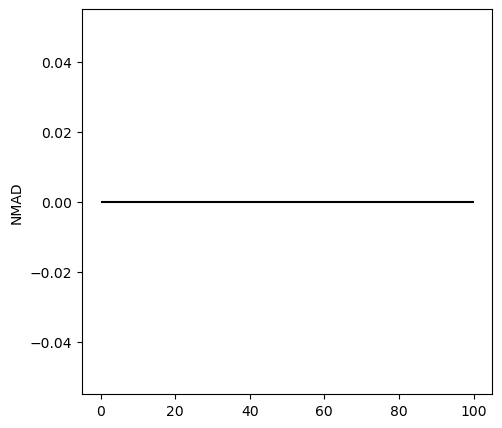

In [21]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.ylabel('NMAD')
plt.hlines(0,0,100,color='k')
plt.errorbar(bins[0:-1]+binwidth,MADs_qs[1,:],yerr=reformat_error(MADs_qs),ecolor='red',fmt='.',capsize=3,xerr=xerr/2)
#plt.ylim(-0.005,0.1)
plt.xlim(-0.05,15)
plt.xlabel('SNR')
plt.grid()

plt.subplot(1,3,2)
plt.hlines(0,0,100,color='k')
plt.ylabel('Bias of Residuals')
plt.errorbar(bins[0:-1]+binwidth,BIASs_qs[1,:],yerr=reformat_error(BIASs_qs),ecolor='red',fmt='.',capsize=3,xerr=xerr/2)
#plt.ylim(-0.25,0.05)
plt.xlim(-0.05,15)
plt.xlabel('SNR')
plt.grid()

plt.subplot(1,3,3)
plt.ylabel(r'Outlier Rate $\eta$ [frac]')
plt.hlines(0,0,100,color='k')
plt.errorbar(bins[0:-1]+binwidth,ETAs_qs[1,:],yerr=reformat_error(ETAs_qs),ecolor='red',fmt='.',capsize=3,xerr=xerr/2)
#plt.ylim(-0.05,1.05)
plt.xlim(-0.05,15)
plt.xlabel('SNR')
plt.grid()

plt.suptitle('LS10 Data Metrics vs SNR')
plt.show()

In [ ]:
#I only recoreded the SNR for my first test chunck
residuals_scaled_PS = ((all_y_hat - all_z.squeeze())/(1+all_z.squeeze()))[0:len(snr_PS)]

MADs, BIASs, ETAs, bins = get_metrics_SNR(residuals_scaled_PS,snr_PS)

#compute IQR interval
MADs_qs = np.quantile(MADs,q=[0.025,0.5,0.975],axis=1)
BIASs_qs = np.quantile(BIASs,q=[0.025,0.5,0.975],axis=1)
ETAs_qs = np.quantile(ETAs,q=[0.025,0.5,0.975],axis=1)

In [ ]:
binwidth = (bins[1::] - bins[0:-1])/2

xerr = np.zeros((2,len(binwidth)))
xerr[0,:] = binwidth
xerr[1,:] = binwidth

In [ ]:
#plot the result
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.ylabel('NMAD')
plt.hlines(0,0,300,color='k')
plt.errorbar(bins[0:-1]+binwidth,MADs_qs[1,:],yerr=reformat_error(MADs_qs),ecolor='red',fmt='.',capsize=3,xerr=xerr/2)
#plt.ylim(-0.005,0.1)
plt.xlim(-3,300)
plt.xlabel('SNR')
plt.grid()

plt.subplot(1,3,2)
plt.hlines(0,0,300,color='k')
plt.ylabel('Bias of Residuals')
plt.errorbar(bins[0:-1]+binwidth,BIASs_qs[1,:],yerr=reformat_error(BIASs_qs),ecolor='red',fmt='.',capsize=3,xerr=xerr/2)
#plt.ylim(-0.25,0.05)
plt.xlim(-3,300)
plt.xlabel('SNR')
plt.grid()

plt.subplot(1,3,3)
plt.ylabel(r'Outlier Rate $\eta$ [frac]')
plt.hlines(0,0,300,color='k')
plt.errorbar(bins[0:-1]+binwidth,ETAs_qs[1,:],yerr=reformat_error(ETAs_qs),ecolor='red',fmt='.',capsize=3,xerr=xerr/2)
#plt.ylim(-0.05,1.05)
plt.xlim(-3,300)
plt.xlabel('SNR')
plt.grid()

plt.suptitle('PS Data Metrics vs SNR')
plt.show()

In [ ]:
### I imagine there is a pretty signficant correlation between SNR and redshift. If not that would be awesome.



# Look at some brickIDs to understand how to grab data

In [20]:
DF2 = pd.read_csv('./../data/redshifts_zhou23/myresult.csv')

In [30]:
DF2['brickid']

0          595236
1          405423
2          373981
3          402603
4          621756
            ...  
4047116    476482
4047117    366286
4047118    496930
4047119    442555
4047120    477777
Name: brickid, Length: 4047121, dtype: int64

# Okay so lets comapre that to Zhou2023, the DESI main photometric redshift catalog, using AstroLab: 

#### https://datalab.noirlab.edu/query.php?name=ls_dr9.photo_z_9p1 (NOTE! ls_dr10.photo_z is available!)
 
SELECT TOP 10 p.z_phot_mean, p.z_spec,  t.ra, t.dec, p.brickid, p.kfold, p.ls_id, p.objid, p.release, p.survey, p.training, p.z_phot_l68, p.z_phot_l95, p.z_phot_median, p.z_phot_std, p.z_phot_u68, p.z_phot_u95
FROM ls_dr9.photo_z_9p1 p
INNER JOIN ls_dr9.tractor t ON p.ls_id = t.ls_id
WHERE p.z_spec > -1 AND t.dec > -30

In [107]:
DF2 = pd.read_csv('./../data/redshifts_zhou23/myresult.csv')
print('original number of samples: ',len(DF2))
DF2 = DF2[DF2['z_spec'] <= 1.6]
print('remove all above ZMAX=1.6: ',len(DF2))
DF2 = DF2[DF2['training'] == 'f']
print('remove all where was used for training: ',len(DF2))

original number of samples:  4047121
remove all above ZMAX=1.6:  3657315
remove all where was used for training:  1460094


In [108]:
DF2

Index(['z_phot_mean', 'z_spec', 'ra', 'dec', 'brickid', 'kfold', 'ls_id',
       'objid', 'release', 'survey', 'training', 'z_phot_l68', 'z_phot_l95',
       'z_phot_median', 'z_phot_std', 'z_phot_u68', 'z_phot_u95'],
      dtype='object')

In [109]:
np.unique(DF2['survey'].values) #look close

array(['2dFLenS', 'AGES', 'BOSS', 'C3R2', 'COSMOS2015', 'DEEP2',
       'DEEP2+3', 'DESI-BGS', 'DESI-ELG', 'DESI-LRG', 'DESI-QSO', 'GAMA',
       'OzDES', 'SDSS', 'SDSS-QSO', 'VIPERS', 'VVDS', 'WiggleZ',
       'eBOSS-ELG', 'eBOSS-LRG'], dtype=object)

### Given that this should be approximately my sample, we can use their reported mean and std to compute a gaussian distribution, then create PIT + CDELoss estimates

In [79]:
from scipy.stats import norm
#I should here exclude the training data; While Zhou23 doesn't explicitly model each output as a Gaussian, I think the simplest
#interpretation of the PDF they make available is to extract a Gaussian from their reported data
PZ = DF2['z_phot_mean'].values[DF2['training'].values == 'f']
PZ_err = DF2['z_phot_std'].values[DF2['training'].values == 'f']
Redshift = DF2['z_spec'].values[DF2['training'].values == 'f']

CDFs = norm.cdf(x=Redshift,loc=PZ,scale=PZ_err)

#CDEs = norm.pdf(x=CLASS_BINS_npy,loc=BECKPZ[wps_mask],scale=BECKPZ_err[wps_mask])
PZ_err_MINI = np.min(PZ_err[PZ_err > 0])
PZ_err[PZ_err==0] = PZ_err_MINI
CDEs = np.exp(-1*np.square(CLASS_BINS_npy[0:N_CLASSES][None,:] - PZ[:,None]) / 2 / np.square(PZ_err[:,None]))

#this correction turns things that have errors below my bandwidth to a delta function.
for i in np.where(np.sum(CDEs,1)==0)[0]:
    j = np.argmin(np.abs(CLASS_BINS_npy - PZ[i]))
    CDEs[i,j] = 1

#re-normalize
CDEs = CDEs / np.sum(CDEs,1)[:,None]
assert np.allclose(np.sum(CDEs,1),1)

In [80]:
CDELOSS, CDELOSS_se = cde_loss(normalize(CDEs,np.linspace(0.0,1.6,400)), CLASS_BINS_npy[0:N_CLASSES], Redshift)
print('Zhou23 cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))

Zhou23 cde_loss:  -13.931618  +/-  0.014869


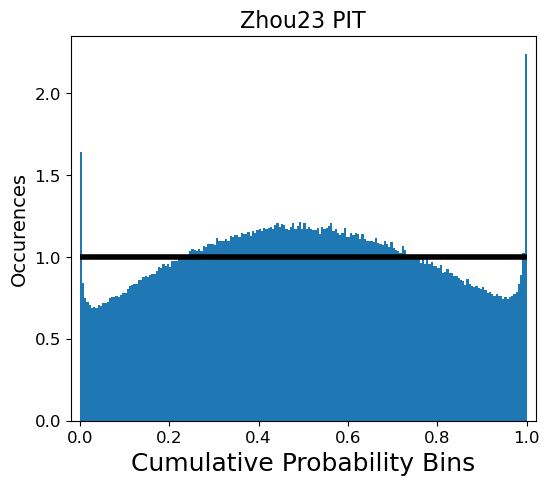

In [77]:
n_classes=200
Pbins=np.linspace(0,1,n_classes+1)
#draw the line that is if it was a perfect distribution. it would have..
#len(PIT)/180 #number in each bin
fig = plt.figure(figsize=(6,5))
plt.hlines(1,0,1,colors='k',linestyles='solid',linewidth=4.0)
plt.xlim(0-0.02,1+0.02)
plt.hist(CDFs,Pbins,density=True)
plt.title('Zhou23 PIT',fontsize=16)
plt.xlabel('Cumulative Probability Bins',fontsize=18)
plt.ylabel('Occurences',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
#if save==True:
#plt.savefig(f'./../IMAGES/BECK_V1p2_PIT.png',bbox_inches="tight",dpi=600)

### Looks like we need to perform a cross match, here is how we can do it:

In [111]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

def xmatch(ra1,dec1,ra2,dec2,maxdist=None,units='deg',method='astropy',**kwargs):

    """Cross-match two sets of ra & dec coordinates locally (i.e. all coordinates are in RAM).

    The function will search for counterparts of ra1/dec1 coordinates
    in the in ra2/dec2 coordinate set, i.e. one can consider ra2/dec2
    to be the catalog that will be searched.

    Parameters
    ----------
    ra1, dec1: 1-d array-like sequences
        RA and declination of first coordinate set, in units of `units`

    ra2, dec2: 1-d array-like sequences
        RA and declination of second coordinate set, in units of `units`

    maxdist : float or None
        If not `None`, then it is the maximum angular distance (in
        units of `units`) to be considered. All distances greater than
        that will be considered non-matches. If `None`, then all
        ra1/dec1 will have matches in ra2/dec2.

    units : str
        Units of `ra1`, `dec1`, `ra2`, `dec2`. Default: 'deg' (decimal degrees).

    method : str
        Currently only astropy's :func:`match_to_catalog_sky()` method
        is supported, i.e. the default 'astropy'.

    Other Parameters
    ----------------
    nthneighbor : int, optional
        If ``method='astropy'``. Which closest neighbor to search for.
        Typically ``1`` is desired here, as that is correct for
        matching one set of coordinates to another. The next likely
        use case is ``2``, for matching a coordinate catalog against
        *itself* (``1`` is inappropriate because each point will find
        itself as the closest match).

    Returns
    -------
    idx : 1-d array
        Index values of the ra1/dec1 counterparts found in
        ra2/dec2. Thus ra2[idx], dec2[idx] will select from the
        ra2/dec2 catalog the matched counterparts of the ra1/dec1
        coordinate pairs.

        If `maxdist` was not `None` but a number instead, then 'idx'
        only contains the objects matched up to the `maxdist` radius.

    dist2d : 1-d array
        The angular distances of the matches found in the ra2/dec2
        catalog. In units of `units`.

        If `maxdist` was not `None` but a number instead, then
        'dist2d' only contains the objects matched up to the `maxdist`
        radius.

    """

    if method == 'astropy':
        unit = getattr(u,units)
        c1 = SkyCoord(ra=ra1*unit, dec=dec1*unit)
        c2 = SkyCoord(ra=ra2*unit, dec=dec2*unit)
        idx, dist2d, dist3d = c1.match_to_catalog_sky(c2,**kwargs)

        if maxdist is not None:
            sel = (dist2d <= maxdist*unit)
            idx = idx[sel]
            dist2d = dist2d[sel]
            
    return idx, dist2d


In [188]:
all_Zhou_residuals_scaled = []
my_test_mask = []
all_Zhou_redshifts = []
all_Zhou_z_phot_mean = []
all_Zhou_z_phot_std = []

for rank in tqdm(range(16)):
    MSD = datasets.MantisShrimpDataset(kind='test',WORLD_RANK=rank,mmap=True,ZMAX=1.6,transform=True)
    
    #we can match each of my test chunks by loading the respective chunk and properly indexing into the DF like so:
    #while that seems funky, I have checked the my predictions match up with the indices of DF in this way.
    test1DF = MSD.DF.iloc[MSD._indices]
    test1DF = test1DF[['ra','dec','z',]]

    #start with all my ra and dec values
    ra1 = test1DF['ra'].values
    dec1 = test1DF['dec'].values
    
    ra2 = DF2['ra'].values
    dec2 = DF2['dec'].values
    #next lets us my masks to get down to the test data:

    #Here is how out samples match onto each other...
    #(ra1[mask],dec1[mask]) == (ra2[idx][mask],dec2[idx][mask])

    idx, dist2d = xmatch(ra1,dec1,ra2,dec2,maxdist=None)
    mask = dist2d < (1.5/3600) * u.deg #must be closer than 1.5 arcsec to accept.

    Zhou_residuals_scaled = (DF2.iloc[idx][mask]['z_phot_mean'] - DF2.iloc[idx][mask]['z_spec'])/(1+DF2.iloc[idx][mask]['z_spec'])

    all_Zhou_residuals_scaled.append(Zhou_residuals_scaled)
    my_test_mask.append(mask)
    all_Zhou_redshifts.append(DF2.iloc[idx][mask]['z_spec'])
    all_Zhou_z_phot_mean.append(DF2.iloc[idx][mask]['z_phot_mean'])
    all_Zhou_z_phot_std.append(DF2.iloc[idx][mask]['z_phot_std'])

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [04:33<00:00, 17.11s/it]


In [189]:
my_test_mask = np.concatenate(my_test_mask)
all_Zhou_residuals_scaled = np.concatenate(all_Zhou_residuals_scaled)
all_Zhou_redshifts = np.concatenate(all_Zhou_redshifts)
all_Zhou_z_phot_mean = np.concatenate(all_Zhou_z_phot_mean)
all_Zhou_z_phot_std = np.concatenate(all_Zhou_z_phot_std)

In [143]:
remove_redshift_diff_outliers_mask = np.abs(all_Zhou_redshifts - all_z[my_test_mask]) < 1e-3

In [168]:
print('total number of matches between me and Zhou23: ',len(all_Zhou_redshifts))
print('total number after removing redshift mismatches: ',remove_redshift_diff_outliers_mask.sum())

total number of matches between me and Zhou23:  281281
total number after removing redshift mismatches:  281103


In [152]:
MADs, BIASs, ETAs = get_metrics(residuals_scaled[my_test_mask][remove_redshift_diff_outliers_mask], all_z[my_test_mask][remove_redshift_diff_outliers_mask])
MADcal, BIAScal, ETAcal = get_metrics(residuals_scaled_cal[my_test_mask][remove_redshift_diff_outliers_mask], all_z[my_test_mask][remove_redshift_diff_outliers_mask])
MADzhou, BIASzhou, ETAzhou = get_metrics(all_Zhou_residuals_scaled[remove_redshift_diff_outliers_mask], all_Zhou_redshifts[remove_redshift_diff_outliers_mask])


#compute 1-sigma interval equivalent.
MADs_qs = np.quantile(MADs,q=[0.158,0.5,0.841],axis=1)
BIASs_qs = np.quantile(BIASs,q=[0.158,0.5,0.841],axis=1)
ETAs_qs = np.quantile(ETAs,q=[0.158,0.5,0.841],axis=1)

MADcal_qs = np.quantile(MADcal,q=[0.158,0.5,0.841],axis=1)
BIAScal_qs = np.quantile(BIAScal,q=[0.158,0.5,0.841],axis=1)
ETAcal_qs = np.quantile(ETAcal,q=[0.158,0.5,0.841],axis=1)

MADzhou_qs = np.quantile(MADzhou,q=[0.158,0.5,0.841],axis=1)
BIASzhou_qs = np.quantile(BIASzhou,q=[0.158,0.5,0.841],axis=1)
ETAzhou_qs = np.quantile(ETAzhou,q=[0.158,0.5,0.841],axis=1)

In [179]:
def print_metrics(residual_scaled):
    MAD_bootstrap = []
    BIAS_bootstrap = []
    ETA_bootstrap = []
    
    for j in range(1000):
        residual_choice = np.random.choice(residual_scaled,len(residual_scaled),replace=True)
        
        MAD = 1.4826*np.median(abs(residual_choice - np.median(residual_choice)))
        BIAS = np.mean(residual_choice)
        ETA = np.sum(abs(residual_choice)>=0.05)/len(residual_choice)

        MAD_bootstrap.append(MAD)
        BIAS_bootstrap.append(BIAS)
        ETA_bootstrap.append(ETA)

    MAD_boostrap = np.array(MAD_bootstrap)
    BIAS_bootstrap = np.array(BIAS_bootstrap)
    ETA_bootstrap = np.array(ETA_bootstrap)

    MAD_qs = np.quantile(MAD_boostrap ,q=[0.158,0.5,0.841])
    BIAS_qs = np.quantile(BIAS_bootstrap,q=[0.158,0.5,0.841])
    ETA_qs = 100*np.quantile(ETA_bootstrap,q=[0.158,0.5,0.841])
    
    print('NMAD: {:.6f} + {:.6f} - {:.6f}'.format(MAD_qs[1],MAD_qs[2]-MAD_qs[1],MAD_qs[1]-MAD_qs[0]))
    print('BIAS: {:.6f} + {:.6f} - {:.6f}'.format(BIAS_qs[1],BIAS_qs[2]-BIAS_qs[1],BIAS_qs[1]-BIAS_qs[0]))
    print('ETA (%): {:.6f} + {:.6f} - {:.6f}'.format(ETA_qs[1],ETA_qs[2]-ETA_qs[1],ETA_qs[1]-ETA_qs[0]))

In [180]:
print('My Original Matched Performance: ')
print_metrics(residuals_scaled[my_test_mask][remove_redshift_diff_outliers_mask])
print('\n')
print('My Calibrated Matched Performance: ')
print_metrics(residuals_scaled_cal[my_test_mask][remove_redshift_diff_outliers_mask])
print('\n')
print('Zhou23 Matched Performance: ')
print_metrics(all_Zhou_residuals_scaled[remove_redshift_diff_outliers_mask])

My Original Matched Performance: 
NMAD: 0.019601 + 0.000054 - 0.000048
BIAS: 0.005429 + 0.000072 - 0.000070
ETA (%): 7.930545 + 0.047014 - 0.052706


My Calibrated Matched Performance: 
NMAD: 0.020562 + 0.000047 - 0.000052
BIAS: -0.000143 + 0.000072 - 0.000075
ETA (%): 9.095598 + 0.053361 - 0.047669


Zhou23 Matched Performance: 
NMAD: 0.015085 + 0.000037 - 0.000039
BIAS: -0.004884 + 0.001264 - 0.001422
ETA (%): 6.092251 + 0.043991 - 0.043223


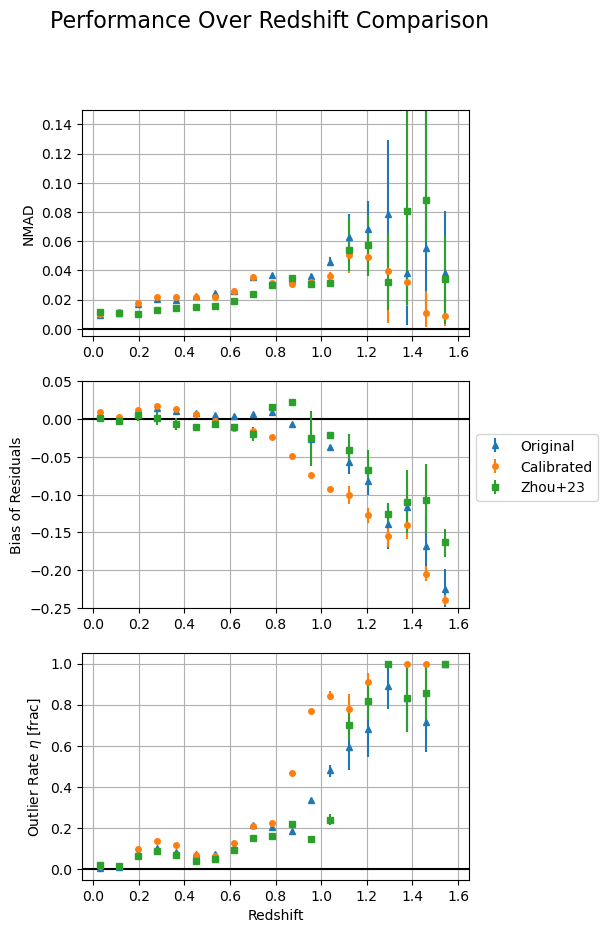

In [187]:
fig = plt.figure(figsize=(5,10))
ax1 = plt.subplot(311)
plt.ylabel('NMAD')
plt.hlines(0,-0.05,1.65,color='k')
plt.errorbar(bins[0:-1]+binstep,MADs_qs[1,:],yerr=reformat_error(MADs_qs),fmt='^',markersize=4)
plt.errorbar(bins[0:-1]+binstep,MADcal_qs[1,:],yerr=reformat_error(MADcal_qs),fmt='o',markersize=4)
plt.errorbar(bins[0:-1]+binstep,MADzhou_qs[1,:],yerr=reformat_error(MADzhou_qs),fmt='s',markersize=4)
plt.ylim(-0.005,0.15)
plt.xlim(-0.05,1.65)
#plt.xlabel('Redshift')
plt.tick_params('x')
plt.grid()

plt.subplot(312,sharex=ax1)
plt.hlines(0,-0.05,1.65,color='k')
plt.ylabel('Bias of Residuals')
plt.errorbar(bins[0:-1]+binstep,BIASs_qs[1,:],yerr=reformat_error(BIASs_qs),fmt='^',markersize=4)
plt.errorbar(bins[0:-1]+binstep,BIAScal_qs[1,:],yerr=reformat_error(BIAScal_qs),fmt='o',markersize=4)
plt.errorbar(bins[0:-1]+binstep,BIASzhou_qs[1,:],yerr=reformat_error(BIASzhou_qs),fmt='s',markersize=4)
plt.ylim(-0.25,0.05)
plt.xlim(-0.05,1.65)
#plt.xlabel('Redshift')
plt.tick_params('x')
plt.grid()

plt.subplot(313,sharex=ax1)
plt.ylabel(r'Outlier Rate $\eta$ [frac]')
plt.hlines(0,-0.05,1.65,color='k')
plt.errorbar(bins[0:-1]+binstep,ETAs_qs[1,:],yerr=reformat_error(ETAs_qs),label='Original',fmt='^',markersize=4)
plt.errorbar(bins[0:-1]+binstep,ETAcal_qs[1,:],yerr=reformat_error(ETAcal_qs),label='Calibrated',fmt='o',markersize=4)
plt.errorbar(bins[0:-1]+binstep,ETAzhou_qs[1,:],yerr=reformat_error(ETAzhou_qs),label='Zhou+23',fmt='s',markersize=4)
plt.ylim(-0.05,1.05)
plt.xlim(-0.05,1.65)
plt.xlabel('Redshift')
plt.grid()

plt.legend(bbox_to_anchor=(1.35,2.0))

plt.suptitle('Performance Over Redshift Comparison',fontsize=16)
plt.show()



# Calculate a fair comparison of CDELoss

In [198]:
from scipy.stats import norm
#I should here exclude the training data; While Zhou23 doesn't explicitly model each output as a Gaussian, I think the simplest
#interpretation of the PDF they make available is to extract a Gaussian from their reported data
PZ = all_Zhou_z_phot_mean[remove_redshift_diff_outliers_mask]
PZ_err = all_Zhou_z_phot_std[remove_redshift_diff_outliers_mask]
Redshift = all_Zhou_redshifts[remove_redshift_diff_outliers_mask]

CDFs = norm.cdf(x=Redshift,loc=PZ,scale=PZ_err)

#CDEs = norm.pdf(x=CLASS_BINS_npy,loc=BECKPZ[wps_mask],scale=BECKPZ_err[wps_mask])
PZ_err_MINI = np.min(PZ_err[PZ_err > 0])
PZ_err[PZ_err==0] = PZ_err_MINI
CDEs = np.exp(-1*np.square(CLASS_BINS_npy[0:N_CLASSES][None,:] - PZ[:,None]) / 2 / np.square(PZ_err[:,None]))

#this correction turns things that have errors below my bandwidth to a delta function.
for i in np.where(np.sum(CDEs,1)==0)[0]:
    j = np.argmin(np.abs(CLASS_BINS_npy - PZ[i]))
    CDEs[i,j] = 1

#re-normalize
CDEs = CDEs / np.sum(CDEs,1)[:,None]
assert np.allclose(np.sum(CDEs,1),1)

In [199]:
CDELOSS, CDELOSS_se = cde_loss(normalize(CDEs,np.linspace(0.0,1.6,400)), CLASS_BINS_npy[0:N_CLASSES], Redshift)
print('Zhou23 cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))

Zhou23 cde_loss:  -14.364222  +/-  0.034247


In [200]:
CDELOSS, CDELOSS_se = cde_loss(normalize(new_cde[my_test_mask][remove_redshift_diff_outliers_mask],np.linspace(0.0,1.6,400)),
         CLASS_BINS_npy[0:N_CLASSES],
         Redshift)
print('My Calibrated matched onto Zhou23 cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))

My Calibrated matched onto Zhou23 cde_loss:  -11.437131  +/-  0.039129


In [201]:
CDELOSS, CDELOSS_se = cde_loss(normalize(all_cde_hat[my_test_mask][remove_redshift_diff_outliers_mask],np.linspace(0.0,1.6,400)),
         CLASS_BINS_npy[0:N_CLASSES],
         Redshift)
print('My Original matched onto Zhou23 cde_loss: ',np.round(CDELOSS,6),' +/- ',np.round(CDELOSS_se,6))

My Original matched onto Zhou23 cde_loss:  -11.96762  +/-  0.030736
